In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load data
df = pd.read_csv('cancer_reg.csv', encoding='utf-8', encoding_errors='ignore')
print(f"Initial dataset shape: {df.shape}")
print(f"Initial missing values: {df.isnull().sum().sum()}")

Initial dataset shape: (3047, 34)
Initial missing values: 3046


In [24]:
# 1. DATA CLEANING PIPELINE

# Drop irrelevant columns for ML model
# Geography is county name - not useful for prediction, too many unique values
columns_to_drop = ['Geography']
if 'Geography' in df.columns:
    df = df.drop(columns=['Geography'])
    print("Dropped 'Geography' column (county names)")

# Handle target variable
if 'TARGET_deathRate' not in df.columns:
    print("Warning: TARGET_deathRate column not found!")
    # Check for similar column names
    target_cols = [col for col in df.columns if 'target' in col.lower() or 'death' in col.lower()]
    print(f"Possible target columns: {target_cols}")

Dropped 'Geography' column (county names)


In [25]:
# 2. MISSING VALUES HANDLING
print("\n=== MISSING VALUES ANALYSIS ===")
missing_summary = df.isnull().sum()
missing_pct = (missing_summary / len(df)) * 100

for col in df.columns:
    if missing_summary[col] > 0:
        print(f"{col}: {missing_summary[col]} missing ({missing_pct[col]:.1f}%)")

# Strategy for missing values
columns_to_drop_missing = []
for col in df.columns:
    missing_rate = df[col].isnull().sum() / len(df)
    
    if missing_rate > 0.5:  # Drop columns with >50% missing
        columns_to_drop_missing.append(col)
    elif missing_rate > 0:
        if df[col].dtype in ['object']:
            # For categorical: fill with mode
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            # For numerical: fill with median (robust to outliers)
            df[col] = df[col].fillna(df[col].median())

# Drop columns with excessive missing values
if columns_to_drop_missing:
    df = df.drop(columns=columns_to_drop_missing)
    print(f"Dropped columns with >50% missing: {columns_to_drop_missing}")



=== MISSING VALUES ANALYSIS ===
PctSomeCol18_24: 2285 missing (75.0%)
PctEmployed16_Over: 152 missing (5.0%)
PctPrivateCoverageAlone: 609 missing (20.0%)
Dropped columns with >50% missing: ['PctSomeCol18_24']


In [26]:
# 3. OUTLIER DETECTION AND TREATMENT
print("\n=== OUTLIER TREATMENT ===")
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

# For medical data, capping outliers is better than removing
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower_cap = series.quantile(lower_percentile/100)
    upper_cap = series.quantile(upper_percentile/100)
    return series.clip(lower=lower_cap, upper=upper_cap)

numerical_cols = df.select_dtypes(include=[np.number]).columns
outlier_cols = []

for col in numerical_cols:
    outliers = detect_outliers_iqr(df[col])
    outlier_pct = (outliers.sum() / len(df)) * 100
    
    if outlier_pct > 5:  # Cap outliers in columns with >5% outliers
        df[col] = cap_outliers(df[col])
        outlier_cols.append(col)
        print(f"Capped outliers in {col}: {outlier_pct:.1f}% outliers")



=== OUTLIER TREATMENT ===
Capped outliers in avgAnnCount: 15.1% outliers
Capped outliers in avgDeathsPerYear: 11.5% outliers
Capped outliers in popEst2015: 13.5% outliers
Capped outliers in studyPerCap: 16.5% outliers
Capped outliers in AvgHouseholdSize: 6.6% outliers
Capped outliers in PctWhite: 5.7% outliers
Capped outliers in PctBlack: 13.0% outliers
Capped outliers in PctAsian: 10.6% outliers
Capped outliers in PctOtherRace: 9.7% outliers
Capped outliers in BirthRate: 5.4% outliers


In [27]:
# 4. DATA TYPE OPTIMIZATION
print("\n=== DATA TYPE OPTIMIZATION ===")
# Convert percentage columns to proper range if they're not already
percentage_cols = [col for col in df.columns if 'Pct' in col or 'Percent' in col]
for col in percentage_cols:
    if df[col].max() > 100:
        print(f"Warning: {col} has values > 100, check data")



=== DATA TYPE OPTIMIZATION ===


In [28]:
# 5. FEATURE ENGINEERING
print("\n=== FEATURE ENGINEERING ===")
# Create additional features that might be predictive

# Population density (if we have area data, we don't but we can create relative measures)
if 'popEst2015' in df.columns and 'AvgHouseholdSize' in df.columns:
    df['PopulationDensityProxy'] = df['popEst2015'] / df['AvgHouseholdSize']

# Healthcare access composite score
healthcare_cols = [col for col in df.columns if 'Coverage' in col]
if len(healthcare_cols) > 0:
    df['HealthcareAccess'] = df[healthcare_cols].mean(axis=1)

# Education level composite
education_cols = [col for col in df.columns if ('Pct' in col and ('HS' in col or 'Bach' in col or 'Col' in col))]
if len(education_cols) > 0:
    # Higher education percentage (bachelor's degree)
    bach_cols = [col for col in education_cols if 'Bach' in col]
    if bach_cols:
        df['HighEducation'] = df[bach_cols].mean(axis=1)

# Age-related features
age_cols = [col for col in df.columns if 'Age' in col]
if len(age_cols) >= 2:
    df['AgeDifference'] = df['MedianAgeFemale'] - df['MedianAgeMale']



=== FEATURE ENGINEERING ===


In [29]:
# 6. REMOVE DUPLICATES
print("\n=== DUPLICATE REMOVAL ===")
initial_shape = df.shape[0]
df = df.drop_duplicates()
duplicates_removed = initial_shape - df.shape[0]
if duplicates_removed > 0:
    print(f"Removed {duplicates_removed} duplicate rows")



=== DUPLICATE REMOVAL ===


In [30]:
# 7. FINAL DATA QUALITY CHECK
print("\n=== FINAL DATA QUALITY SUMMARY ===")
print(f"Final dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Data types:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"  {dtype}: {len(cols)} columns")

# Check target variable
if 'TARGET_deathRate' in df.columns:
    print(f"\nTarget variable stats:")
    print(f"  Range: {df['TARGET_deathRate'].min():.2f} - {df['TARGET_deathRate'].max():.2f}")
    print(f"  Mean: {df['TARGET_deathRate'].mean():.2f}")
    print(f"  Std: {df['TARGET_deathRate'].std():.2f}")

print("\nData cleaning completed successfully!")


=== FINAL DATA QUALITY SUMMARY ===
Final dataset shape: (3047, 36)
Missing values: 0
Data types:
  float64: 34 columns
  int64: 1 columns
  object: 1 columns

Target variable stats:
  Range: 59.70 - 362.80
  Mean: 178.66
  Std: 27.75

Data cleaning completed successfully!


In [31]:
# 8. PREPARE DATA FOR MACHINE LEARNING
print("=== PREPARING DATA FOR ML ===")

# Separate features and target
target_col = 'TARGET_deathRate'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset")

X = df.drop(columns=[target_col])
y = df[target_col]

# Handle any remaining categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Encoding categorical columns: {list(categorical_cols)}")
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

=== PREPARING DATA FOR ML ===
Encoding categorical columns: ['binnedInc']
Features shape: (3047, 35)
Target shape: (3047,)
Feature columns: ['avgAnnCount', 'avgDeathsPerYear', 'incidenceRate', 'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc', 'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'AvgHouseholdSize', 'PercentMarried', 'PctNoHS18_24', 'PctHS18_24', 'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over', 'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage', 'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage', 'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate', 'PopulationDensityProxy', 'HealthcareAccess', 'HighEducation', 'AgeDifference']


In [32]:
# 9. TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# 10. FEATURE SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")


Train set: (2437, 35)
Test set: (610, 35)
Feature scaling completed


In [33]:
# 11. MODEL TRAINING AND EVALUATION
print("=== MODEL TRAINING ===")

# Dictionary to store model results
model_results = {}

# Model 1: Linear Regression
print("\n1. Linear Regression")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

model_results['Linear Regression'] = {
    'RMSE': lr_rmse,
    'MAE': lr_mae,
    'R²': lr_r2,
    'model': lr_model
}

print(f"  RMSE: {lr_rmse:.4f}")
print(f"  MAE: {lr_mae:.4f}")
print(f"  R²: {lr_r2:.4f}")

# Model 2: Random Forest
print("\n2. Random Forest Regression")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # Random Forest doesn't need scaling
rf_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

model_results['Random Forest'] = {
    'RMSE': rf_rmse,
    'MAE': rf_mae,
    'R²': rf_r2,
    'model': rf_model
}

print(f"  RMSE: {rf_rmse:.4f}")
print(f"  MAE: {rf_mae:.4f}")
print(f"  R²: {rf_r2:.4f}")

# Model 3: Random Forest with Hyperparameter Tuning
print("\n3. Random Forest with GridSearch (this may take a few minutes)")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_best_pred = rf_best.predict(X_test)

rf_best_mse = mean_squared_error(y_test, rf_best_pred)
rf_best_rmse = np.sqrt(rf_best_mse)
rf_best_mae = mean_absolute_error(y_test, rf_best_pred)
rf_best_r2 = r2_score(y_test, rf_best_pred)

model_results['Random Forest (Tuned)'] = {
    'RMSE': rf_best_rmse,
    'MAE': rf_best_mae,
    'R²': rf_best_r2,
    'model': rf_best,
    'best_params': rf_grid.best_params_
}

print(f"  Best parameters: {rf_grid.best_params_}")
print(f"  RMSE: {rf_best_rmse:.4f}")
print(f"  MAE: {rf_best_mae:.4f}")
print(f"  R²: {rf_best_r2:.4f}")

=== MODEL TRAINING ===

1. Linear Regression
  RMSE: 20.0676
  MAE: 14.8421
  R²: 0.5078

2. Random Forest Regression
  RMSE: 19.2188
  MAE: 14.0377
  R²: 0.5486

3. Random Forest with GridSearch (this may take a few minutes)
  Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
  RMSE: 19.1042
  MAE: 13.9695
  R²: 0.5540


In [34]:
# 12. MODEL COMPARISON
print("\n=== MODEL COMPARISON ===")
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'RMSE': [result['RMSE'] for result in model_results.values()],
    'MAE': [result['MAE'] for result in model_results.values()],
    'R²': [result['R²'] for result in model_results.values()]
}).sort_values('R²', ascending=False)

print(comparison_df)

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")


=== MODEL COMPARISON ===
                   Model       RMSE        MAE        R²
2  Random Forest (Tuned)  19.104192  13.969537  0.553960
1          Random Forest  19.218844  14.037723  0.548590
0      Linear Regression  20.067631  14.842099  0.507837

Best model: Random Forest (Tuned)


=== FEATURE IMPORTANCE ANALYSIS ===
Top 15 Most Important Features:
                   feature  importance
17       PctBachDeg25_Over    0.220371
2            incidenceRate    0.207978
16            PctHS25_Over    0.046709
3                medIncome    0.042102
24  PctPublicCoverageAlone    0.034519
1         avgDeathsPerYear    0.033816
28            PctOtherRace    0.023535
5           povertyPercent    0.022227
20      PctPrivateCoverage    0.021979
26                PctBlack    0.021329
14              PctHS18_24    0.020584
29    PctMarriedHouseholds    0.020118
19    PctUnemployed16_Over    0.019593
33           HighEducation    0.018667
18      PctEmployed16_Over    0.018267


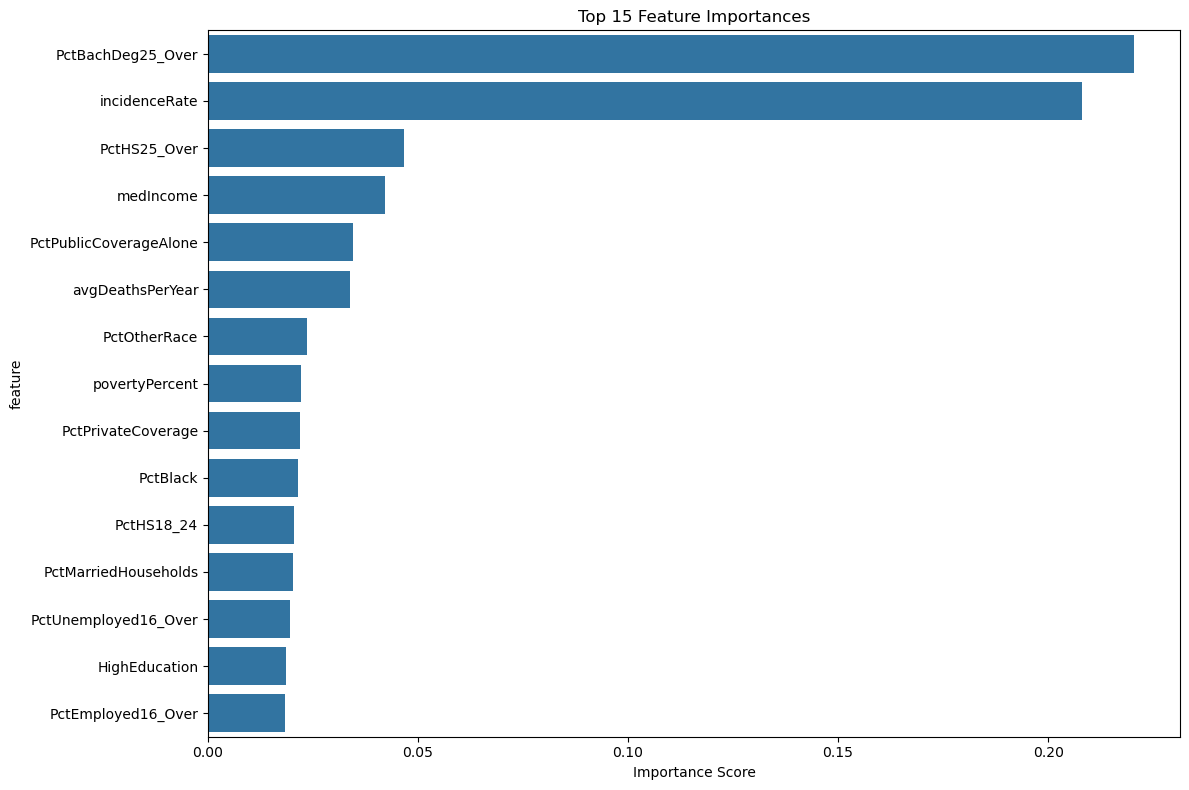

In [35]:
# 13. FEATURE IMPORTANCE ANALYSIS
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from the best Random Forest model
if 'Random Forest' in best_model_name:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()



=== PREDICTION VISUALIZATION ===


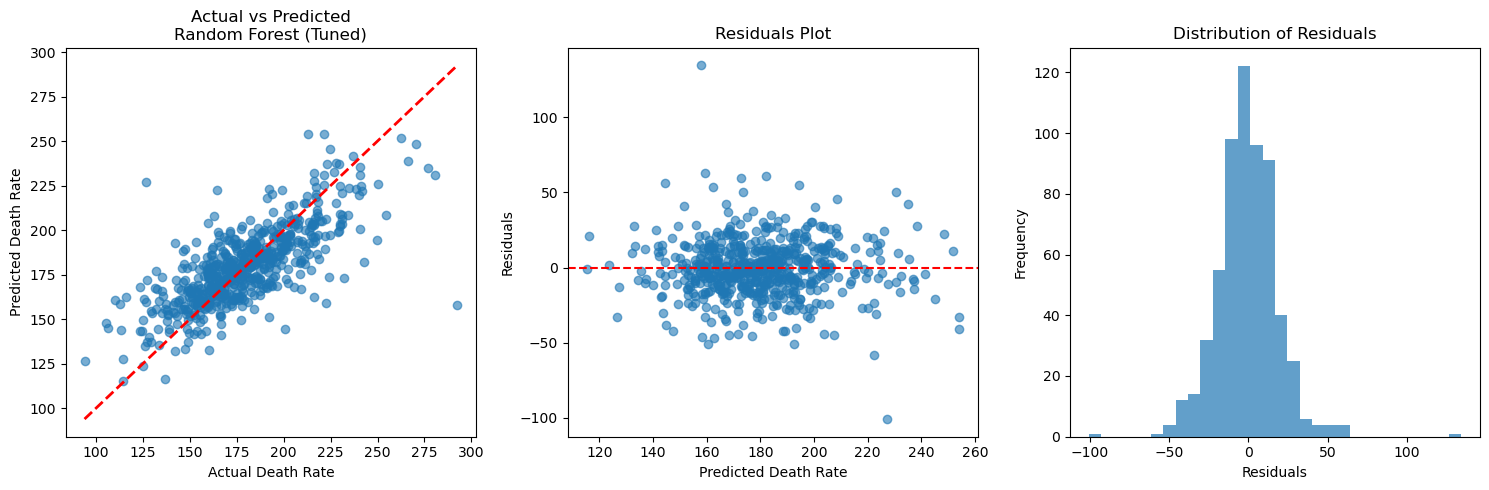

In [36]:
# 14. MODEL PREDICTIONS VISUALIZATION
print("\n=== PREDICTION VISUALIZATION ===")
best_pred = best_model.predict(X_test) if 'Random Forest' in best_model_name else best_model.predict(X_test_scaled)

plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, best_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Death Rate')
plt.ylabel('Predicted Death Rate')
plt.title(f'Actual vs Predicted\n{best_model_name}')

# Residuals plot
plt.subplot(1, 3, 2)
residuals = y_test - best_pred
plt.scatter(best_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Death Rate')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# Distribution of residuals
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

In [37]:
# 15. FINAL MODEL SUMMARY
print("=== FINAL MODEL SUMMARY ===")
print(f"Best Model: {best_model_name}")
print(f"R² Score: {model_results[best_model_name]['R²']:.4f}")
print(f"RMSE: {model_results[best_model_name]['RMSE']:.4f}")
print(f"MAE: {model_results[best_model_name]['MAE']:.4f}")

if 'best_params' in model_results[best_model_name]:
    print(f"Best Parameters: {model_results[best_model_name]['best_params']}")

print(f"\nModel Performance Interpretation:")
print(f"- The model explains {model_results[best_model_name]['R²']*100:.1f}% of the variance in cancer death rates")
print(f"- Average prediction error: ±{model_results[best_model_name]['MAE']:.2f} deaths per 100,000 people")
print(f"- Root Mean Square Error: {model_results[best_model_name]['RMSE']:.2f}")

print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")

=== FINAL MODEL SUMMARY ===
Best Model: Random Forest (Tuned)
R² Score: 0.5540
RMSE: 19.1042
MAE: 13.9695
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Model Performance Interpretation:
- The model explains 55.4% of the variance in cancer death rates
- Average prediction error: ±13.97 deaths per 100,000 people
- Root Mean Square Error: 19.10

=== PIPELINE COMPLETED SUCCESSFULLY ===
